In [1]:
using LinearAlgebra, Plots
# 函数定义
@inline function skew(V)
    return [0 -V[3] V[2]; V[3] 0 -V[1]; -V[2] V[1] 0]
end

function comp_A(p)
    e0 = p[1]
    e = p[2:4]
    return (e0^2 - transpose(e)*e)*I(3) + 2*e*transpose(e) + 2*e0*skew(e)
end

function comp_G(p)
    e0 = p[1]
    e = p[2:4]
    return [-e e0*I(3)-skew(e)]
end

@inline function comp_dp(p, omegaP)
    return transpose(comp_G(p))*omegaP/2
end

function comp_D(U, V, q)
    UqT = U*transpose(q)
    return (I(size(UqT, 1)) - UqT./(transpose(q)*U))*V
end

function comp_ddv(q0, U, V, v, dv)
    J = [120 0 0; 0 120 0; 0 0 30] # 转动惯量
    nP = [0; 0; 0]
    m = 30 # 质量
    g = 9.8 # 重力加速度
    uz = [0; 0; 1] # 重力方向

    q = q0 + V*v - U*(1 - sqrt(1 - sum(v.*v)))
    D = comp_D(U, V, q)
    G = comp_G(q)
    MEq = 4*transpose(G*D)*J*G*D

    dq = D*dv
    dG = comp_G(dq)
    A = comp_A(q)
    gEq = 4*(dq'*dq/(q'*q0))*D'*G'*J*G*q0 + 8*D'*dG'*J*dG*q - 2*D'*G'*(m*g*skew(uz)*A'*uz + nP)
    return MEq\gEq
end

function RK4(q0, U, V, v, dv, h)
    k1 = comp_ddv(q0, U, V, v, dv)
    k2 = comp_ddv(q0, U, V, v + dv*h/2 + k1*h^2/8, dv + k1*h/2)
    k3 = comp_ddv(q0, U, V, v + dv*h/2 + k1*h^2/8, dv + k2*h/2)
    k4 = comp_ddv(q0, U, V, v + dv*h + k3*h^2/2, dv + k3*h)
    v = v + dv*h + (k1 + k2 + k3)*h^2/6
    dv = dv + (k1 + 2*k2 + 2*k3 + k4)*h/6
    return [v dv]
end

RK4 (generic function with 1 method)

In [2]:
# 参数设置
q0 = [1; 0; 0; 0]
epsilon = 1e-12
omegaP0 = [epsilon; epsilon; 13.5]
tStep = 1e-3
tList = collect(0:tStep:100)
qList = zeros((4, length(tList)))
coordinate = zeros((3, length(tList)))

3×100001 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [3]:
# 初始化
qList[:, 1] = deepcopy(q0)
q = deepcopy(q0)
dq = comp_dp(q, omegaP0)
U = deepcopy(q0)
V = transpose(comp_G(q0))
v = transpose(V)*(q - q0)
dv = transpose(V)*dq

3-element Vector{Float64}:
 5.0e-13
 5.0e-13
 6.75

In [4]:
# 迭代计算
#for t = 2:2
for t = 2:length(tList)
    if norm(v) > 0.75
        q0 = deepcopy(q)
        U = deepcopy(q0)
        V = transpose(comp_G(q0))
        v = transpose(V)*(q - q0)
        dv = transpose(V)*dq
    end
    v_update = RK4(q0, U, V, v, dv, tStep)
    v = deepcopy(v_update[:, 1])
    dv = deepcopy(v_update[:, 2])
    u = 1 - sqrt(1 - sum(v.*v))
    q = q0 + V*v - U*u
    qList[:, t] = deepcopy(q)
    coordinate[:, t] = comp_A(q)*[0; 0; 1]
    D = comp_D(U, V, q)
    dq = D*dv
end

In [5]:
# 作图
plot(coordinate[1, :], coordinate[2, :], label = "TopView")
xlabel!("X")
ylabel!("Y")
savefig("5.1-fig1.png")

"c:\\Users\\17739\\Git\\Kinematics-Dynamics\\Computer-aided Kinematics and Dynamics-Haug\\src\\5.1-fig1.png"

┌ Info: Saved animation to c:\Users\17739\Git\Kinematics-Dynamics\Computer-aided Kinematics and Dynamics-Haug\src\5.1-anim1.gif
└ @ Plots C:\Users\17739\.julia\packages\Plots\3BCH5\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\17739\\Git\\Kinematics-Dynamics\\Computer-aided Kinematics and Dynamics-Haug\\src\\5.1-anim1.gif")
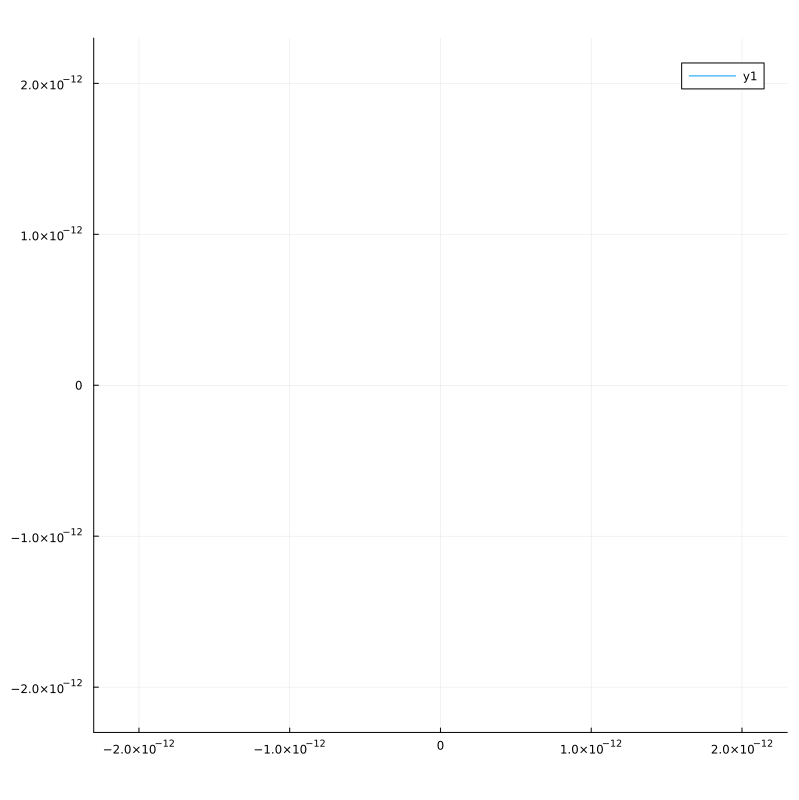

In [6]:
# 动画
anim = @animate for i in collect(1:100:100001)
    plot(coordinate[1, 1:i], coordinate[2, 1:i], xlim=(-2.3e-12, 2.3e-12), ylim=(-2.3e-12, 2.3e-12), aspect_ratio = 1, size = (800, 800))
end

gif(anim, "5.1-anim1.gif", fps = 50)